# TL; DR:
- least_squares() beats minimize() in speed and reproducibility
- Trying to minimize futile cycles by penalizing all flux does not work well
  - The optimizer does not always converge, particularly with minimize()
  - When it does converge, the constraint introduces artifacts into the solution
- An alternative approach to break futile cycles seems to work well

Changes were needed to this notebook to reproduce its behavior before the branch 'futile' and revision 39da4196528af413112ecf304a2dea070d023180, implementing the very changes it suggests.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix

from mosmo.model.core import Molecule, Reaction, Pathway
from mosmo.model.reaction_network import ReactionNetwork
from mosmo.knowledge import kb
from mosmo.calc import fba_gd

KB = kb.configure_kb()

jax.config.update('jax_enable_x64', True)

# Setup: PTS + glycolysis + PPP; objectives from [R5P, E4P, PEP, acCoA]

In [2]:
glycolysis = KB.find(KB.pathways, 'glycolysis')[0]
ppp = KB.find(KB.pathways, 'pentose phosphate')[0]
pts = KB.get(KB.reactions, 'pts.glc')

r5p = KB('Rib.D.5P')
e4p = KB('Ery.D.4P')
pep = KB('pep')
pyr = KB('pyr')
acCoA = KB('accoa')

concs = {KB(met_id): conc for met_id, conc in [
    ('accoa', 0.61),
    ('adp', 0.55),
    ('amp', 0.28),
    ('atp', 9.6),
    ('co2', 0.01),
    ('coa', 1.4),
    ('h+', 1e-7),
    ('h2o', 55500.),
    ('nad.ox', 2.6),
    ('nad.red', 0.083),
    ('nadp.ox', 0.0021),
    ('nadp.red', 0.12),
    ('pep', 0.18),
    ('pyr', 0.1),  # guess
    ('pi', 10.),  # guess
    ('Rib.D.5P', 0.8),  # guess
    ('Ery.D.4P', 0.8),  # guess    
    ('Glc.D.ext', 10.),  # arbitrary
]}

network = ReactionNetwork([pts] + glycolysis.steps + ppp.steps)
boundaries = concs.keys()
intermediates = [met for met in network.reactants if met not in boundaries]

# Legacy Code

## Straight glycolysis to acCoA

In [3]:
import time

# Reconstructing existing code, before 39da4196528af413112ecf304a2dea070d023180
def l_pt5(residual):
    return jnp.sum(jnp.sqrt(jnp.abs(residual)))

def l2(residual):
    return jnp.sum(jnp.square(residual))

class LegacyObjective(fba_gd.Objective):
    def __init__(self, objective, aggfun=l2):
        self.objective = objective
        self.weight = objective.weight
        self.aggfun = aggfun

    def update_params(self, params):
        self.objective.update_params(params)

    def params(self):
        return self.objective.params()

    def residual(self, velocities, dmdt, params):
        return self.objective.residual(velocities, dmdt, params)

    def loss(self, velocities, dmdt, params):
        return self.objective.weight * self.aggfun(self.objective.residual(velocities, dmdt, params))

class LegacyFbaGd:
    def __init__(self, network, intermediates, objectives, w_fitness=1e4, w_sparsity=1e-4):
        self.network = network
        self.objectives = {
            'steady-state': LegacyObjective(fba_gd.SteadyStateObjective(network, intermediates, weight=w_fitness)),
            'irreversibility': LegacyObjective(fba_gd.IrreversibilityObjective(network, weight=w_fitness)),
            'sparsity': LegacyObjective(fba_gd.VelocityObjective(network, {r: 0 for r in network.reactions}, weight=w_sparsity), aggfun=l_pt5),
        }
        self.objectives.update(objectives)

        def loss(v, *params):
            dmdt = self.network.s_matrix @ v
            return sum(objective.loss(v, dmdt, p) for objective, p in zip(self.objectives.values(), params))

        # Cache the jitted loss and jacobian functions
        self._loss_jit = jax.jit(loss)
        self._loss_jac = jax.jit(jax.jacfwd(loss))

    def update_params(self, updates):
        for name, params in updates.items():
            self.objectives[name].update_params(params)

    def solve(self, v0=None, seed=None, **kw_args):
        if v0 is None:
            if seed is None:
                seed = jax.random.PRNGKey(int(time.time() * 1000))
            v0 = jax.random.normal(seed, self.network.shape[1:])

        params = tuple(objective.params() for objective in self.objectives.values())
        soln = scipy.optimize.minimize(fun=self._loss_jit, args=params, x0=v0, jac=self._loss_jac, **kw_args)

        dmdt = self.network.s_matrix @ soln.x
        return fba_gd.FbaResult(v0=v0,
                                velocities=soln.x,
                                dmdt=dmdt,
                                fit=sum(float(self.objectives[name].loss(soln.x, dmdt, None))
                                        for name in ['steady-state', 'irreversibility']))

fba = LegacyFbaGd(
    network,
    intermediates,
    {
        'drivers': LegacyObjective(fba_gd.ProductionObjective(network, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0.})),
    }
)
soln = fba.solve()

In [4]:
for m, dmdt in network.reactants.unpack(soln.dmdt).items():
    print(f'{m.label:>12s}: {dmdt:7.4f} {"[SS]" if m in intermediates else ""}')

      Glc[e]: -0.4219 
         PEP: -0.0034 
         G6P:  0.0000 [SS]
         pyr: -0.0035 
         F6P:  0.0000 [SS]
         ATP: -0.5740 
         ADP:  0.5133 
         FDP: -0.0000 [SS]
          H+:  5.4848 
         H2O: -3.0145 
          Pi:  0.6346 
         GAP:  0.0000 [SS]
        DHAP: -0.0000 [SS]
        NAD+: -0.0974 
         DPG:  0.0000 [SS]
        NADH:  0.0974 
         3PG: -0.0000 [SS]
         2PG: -0.0000 [SS]
         AMP:  0.0607 
         CoA: -0.0521 
       acCoA:  0.0521 
         CO2:  2.4320 
         R5P:  0.0021 
        Ru5P:  0.0000 [SS]
       Sed7P: -0.0000 [SS]
        Xu5P:  0.0000 [SS]
       6PGDL: -0.0000 [SS]
         6PG:  0.0000 [SS]
       NADP+: -4.7597 
       NADPH:  4.7597 
         E4P:  0.0014 


In [5]:
for r, v in network.reactions.unpack(soln.velocities).items():
    print(f"{r.label:>12s}: {v:7.4f}")

      GlcPTS:  0.4219
         PGI: -1.9580
         PFK:  0.2459
         FBP:  0.6191
         FBA: -0.3732
         TPI:  0.3732
       GAPDH:  0.0452
         PGK: -0.0452
         GPM: -0.0452
         ENO:  0.0452
         PYK:  0.3126
         PPS:  0.0607
         PDH:  0.0521
        R5PI: -0.7951
        TKT1: -0.7931
         RPE:  1.5847
      PGLase:  2.3799
       PGLDH:  2.3799
        TALA:  0.7931
        TKT2:  0.7917
       G6PDH:  2.3799


Not a compelling solution. What if we manufacture the known 'best' (or at least intended) solution?

In [6]:
optimal = {KB(rxn_id): v for rxn_id, v in [
    ('pts.glc',  0.03),
    ('pgi', 0.03),
    ('pfk',  0.03),
    ('fbp',  0.),
    ('fba', 0.03),
    ('tpi',  -0.03),
    ('gapdh',  0.06),
    ('pgk', -0.06),
    ('gpm', -0.06),
    ('eno',  0.06),
    ('pyk',  -0.03),
    ('pps',  0.),
    ('pdh',  0.06),
    ('r5pi', 0.),
    ('tkt.c5c5', 0.),
    ('rpe',  0.),
    ('pglase',  0.),
    ('pgldh',  0.),
    ('tal',  0.),
    ('tkt.c5c4',  0.),
    ('g6pdh',  0.),
]}
optimal_array = network.reactions.pack(optimal)
dmdt = network.s_matrix @ optimal_array

for key, obj in fba.objectives.items():
    print(key, obj.residual(optimal_array, dmdt, obj.params()))

steady-state [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
irreversibility [0. 0. 0. 0. 0. 0. 0.]
sparsity [ 0.03  0.03  0.03  0.    0.03 -0.03  0.06 -0.06 -0.06  0.06 -0.03  0.
  0.06  0.    0.    0.    0.    0.    0.    0.    0.  ]
drivers [0. 0. 0. 0. 0.]


In [7]:
jiggle = np.zeros(optimal_array.shape)
# jiggle = 0.00001 * jax.random.normal(jax.random.PRNGKey(0), optimal_array.shape)
soln = fba.solve(v0=optimal_array + jiggle, options={'disp': True})
print(soln.velocities, soln.velocities - optimal_array)
for key, obj in fba.objectives.items():
    print(key, obj.residual(soln.velocities, soln.dmdt, obj.params()))

         Current function value: 0.000226
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 0.03  0.03  0.03  0.    0.03 -0.03  0.06 -0.06 -0.06  0.06 -0.03  0.
  0.06  0.    0.    0.    0.    0.    0.    0.    0.  ] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
steady-state [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
irreversibility [0. 0. 0. 0. 0. 0. 0.]
sparsity [ 0.03  0.03  0.03  0.    0.03 -0.03  0.06 -0.06 -0.06  0.06 -0.03  0.
  0.06  0.    0.    0.    0.    0.    0.    0.    0.  ]
drivers [0. 0. 0. 0. 0.]


/home/fdrusso/.pyenv/versions/3.11.2/envs/mosmo-work/lib/python3.11/site-packages/scipy/optimize/_minimize.py:726: OptimizeWarning: NaN result encountered.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


With minimize() and the above objective:
- jiggle = 0 ==> Warning: NaN result encountered.
- jiggle = _any_ non-zero, even very small ==> Warning: Desired error not necessarily achieved due to precision loss.

**Not** working as intended

## Try it in μM to give more breathing room on the bottom

In [8]:
fba.update_params({'drivers': {acCoA: 60.}})
jiggle = 1e-6 * jax.random.normal(jax.random.PRNGKey(0), optimal_array.shape)
soln = fba.solve(v0=optimal_array*1000 + jiggle, options={'disp': True})
print(soln.velocities, soln.velocities - optimal_array*1000)
for key, obj in fba.objectives.items():
    print(key, obj.residual(soln.velocities, soln.dmdt, obj.params()))

         Current function value: 0.007160
         Iterations: 3
         Function evaluations: 60
         Gradient evaluations: 54
[ 3.00000000e+01  2.99999997e+01  3.00000004e+01 -1.04223516e-06
  3.00000002e+01 -3.00000005e+01  5.99999998e+01 -6.00000000e+01
 -5.99999993e+01  6.00000002e+01 -2.99999988e+01  6.15988716e-07
  6.00000014e+01  3.78261187e-08 -2.82619858e-07  3.59956278e-07
 -2.97940870e-07 -8.21233080e-07 -1.22069593e-06  2.58682919e-07
 -5.52429093e-07] [-4.84827680e-08 -3.34492082e-07  4.26831178e-07 -1.04223516e-06
  1.73691621e-07 -5.18299455e-07 -2.38308267e-07  2.52969201e-08
  7.41733103e-07  1.93318151e-07  1.21295441e-06  6.15988716e-07
  1.44714411e-06  3.78261187e-08 -2.82619858e-07  3.59956278e-07
 -2.97940870e-07 -8.21233080e-07 -1.22069593e-06  2.58682919e-07
 -5.52429093e-07]
steady-state [ 8.38438407e-07 -2.76557143e-06  1.29537472e-06  2.69229806e-06
 -3.44607834e-07 -2.13011347e-07  7.16436183e-07 -9.35051254e-07
 -1.14336324e-06  1.50331579e-06 -1.81

/home/fdrusso/.pyenv/versions/3.11.2/envs/mosmo-work/lib/python3.11/site-packages/scipy/optimize/_minimize.py:726: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


Same result. Comforting, I guess...

## Still using scipy.optimize.minimize, but remove sparsity objective (which is on a very different scale)

In [9]:
fba = LegacyFbaGd(
    network,
    intermediates,
    {'drivers': LegacyObjective(fba_gd.ProductionObjective(network, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0.})),},
    w_sparsity=0.,
)
jiggle = 1e-4 * jax.random.normal(jax.random.PRNGKey(0), optimal_array.shape)
soln = fba.solve(v0=optimal_array + jiggle, options={'disp': True})
print(soln.velocities, soln.velocities - optimal_array)
for r, v in network.reactions.unpack(soln.velocities).items():
    print(f"{r.id:>20}: {v:8.5f}")

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 24
         Function evaluations: 38
         Gradient evaluations: 38
[ 3.00076045e-02  2.99608020e-02  3.00734077e-02  8.16714900e-05
  2.99917362e-02 -2.99917362e-02  5.99988318e-02 -5.99988319e-02
 -5.99988319e-02  5.99988318e-02 -3.00165864e-02  2.50331282e-05
  5.99995535e-02 -1.58681396e-05 -1.55748863e-05  3.09342767e-05
  4.68024767e-05  4.68025114e-05  1.55748573e-05  1.53594329e-05
  4.68025211e-05] [ 7.60451493e-06 -3.91980207e-05  7.34077492e-05  8.16714900e-05
 -8.26381421e-06  8.26380741e-06 -1.16820303e-06  1.16812552e-06
  1.16813932e-06 -1.16817279e-06 -1.65863937e-05  2.50331282e-05
 -4.46469026e-07 -1.58681396e-05 -1.55748863e-05  3.09342767e-05
  4.68024767e-05  4.68025114e-05  1.55748573e-05  1.53594329e-05
  4.68025211e-05]
             pts.glc:  0.03001
                 pgi:  0.02996
                 pfk:  0.03007
                 fbp:  0.00008
                 f

### Manually break futile cycles

In [10]:
fba = LegacyFbaGd(
    network,
    intermediates,
    {
        'drivers': LegacyObjective(fba_gd.ProductionObjective(network, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0.}, weight=100.)),
        'non-futility': LegacyObjective(fba_gd.VelocityObjective(network, {
            KB.get(KB.reactions, 'fbp'): 0.,
            KB.get(KB.reactions, 'pps'): 0.,
        })),
    },
    w_sparsity=0.,
)
jiggle = 1e-2 * jax.random.normal(jax.random.PRNGKey(0), optimal_array.shape)
soln = fba.solve(v0=optimal_array + jiggle, options={'disp': True})
print(soln.velocities)
print(np.sum(np.square(soln.velocities - optimal_array)))
for r, v in network.reactions.unpack(soln.velocities).items():
    print(f"{r.id:>20}: {v:8.5f}")

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 73
         Function evaluations: 138
         Gradient evaluations: 138
[ 3.00806257e-02  2.95968727e-02  2.99197175e-02  3.42800488e-07
  2.99193746e-02 -2.99193746e-02  6.00000000e-02 -6.00000001e-02
 -6.00000000e-02  6.00000000e-02 -2.99194404e-02  6.58226796e-08
  5.99999999e-02 -1.61251062e-04 -1.61251036e-04  3.22501834e-04
  4.83752929e-04  4.83752928e-04  1.61251078e-04  1.61250879e-04
  4.83753035e-04]
1.1050140801855858e-06
             pts.glc:  0.03008
                 pgi:  0.02960
                 pfk:  0.02992
                 fbp:  0.00000
                 fba:  0.02992
                 tpi: -0.02992
               gapdh:  0.06000
                 pgk: -0.06000
                 gpm: -0.06000
                 eno:  0.06000
                 pyk: -0.02992
                 pps:  0.00000
                 pdh:  0.06000
                r5pi: -0.00016
            tkt.c5c5: -0.0

At least it appears to consistently find a solution. Doesn't knock my socks off though.

- Wait, this could be legitimate. We have set an objective for acCoA production, and that is being met exactly (PDH velocity = 0.06000). Some unexpected flux is going through PPP, spending a little extra G6P and getting some NADPH + CO2, but none of our objectives discourage that. If we force 1 G6P => 2 acCoA, or alternatively NADPH = 0, it could consistently find the same (optimal) solution.

In [11]:
fba = LegacyFbaGd(
    network,
    intermediates,
    {
        'drivers': LegacyObjective(
            fba_gd.ProductionObjective(network, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0., KB('Glc.D.ext'): -0.03})),
        'non-futility': LegacyObjective(fba_gd.VelocityObjective(network, {KB('fbp'): 0., KB('pps'): 0.})),
    },
    w_sparsity=0.,
)
jiggle = 1e-1 * jax.random.normal(jax.random.PRNGKey(0), optimal_array.shape)
soln = fba.solve(v0=optimal_array + jiggle, options={'disp': True})
print(np.sum(np.square(soln.velocities - optimal_array)))
print()
for r, v in network.reactions.unpack(soln.velocities).items():
    print(f"{r.id:>20}: {v:8.5f}")

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 83
         Function evaluations: 142
         Gradient evaluations: 142
5.0884430213732544e-11

             pts.glc:  0.03000
                 pgi:  0.03000
                 pfk:  0.03000
                 fbp:  0.00000
                 fba:  0.03000
                 tpi: -0.03000
               gapdh:  0.06000
                 pgk: -0.06000
                 gpm: -0.06000
                 eno:  0.06000
                 pyk: -0.03000
                 pps:  0.00000
                 pdh:  0.06000
                r5pi: -0.00000
            tkt.c5c5: -0.00000
                 rpe:  0.00000
              pglase:  0.00000
               pgldh:  0.00000
                 tal:  0.00000
            tkt.c5c4:  0.00000
               g6pdh:  0.00000


Ok, that's viable

## Using scipy.optimize.least_squares, with catenated residual vectors

In [12]:
objectives = {
    'steady-state': fba_gd.SteadyStateObjective(network, intermediates, weight=1e4),
    'irreversibility': fba_gd.IrreversibilityObjective(network, weight=1e4),
    'drivers': fba_gd.ProductionObjective(network, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0., KB('Glc.D.ext'): -0.03}),
    'non-futility': fba_gd.VelocityObjective(network, {KB('fbp'): 0., KB('pps'): 0.}),
}

def residual(v, *params):
    dmdt = network.s_matrix @ v
    return jnp.concatenate([objective.residual(v, dmdt, p) * np.sqrt(objective.weight)
                            for objective, p in zip(objectives.values(), params)])

# Cache the jitted loss and jacobian functions
_loss_jit = jax.jit(residual)
_loss_jac = jax.jit(jax.jacfwd(residual))

jiggle = 1e-1 * jax.random.normal(jax.random.PRNGKey(0), optimal_array.shape)
v0=optimal_array + jiggle

params = tuple(objective.params() for objective in objectives.values())
soln = scipy.optimize.least_squares(fun=_loss_jit, args=params, x0=v0, jac=_loss_jac)
print(soln.message)

dmdt = network.s_matrix @ soln.x
fba_soln = fba_gd.FbaResult(v0=np.asarray(v0),
                            velocities=np.asarray(soln.x),
                            dmdt=np.asarray(dmdt),
                            fit=sum(np.sum(np.square(objectives[name].loss(soln.x, dmdt, None))) for name in ['steady-state', 'irreversibility']))
print(np.sum(np.square(fba_soln.velocities - optimal_array)))
print()
for r, v in network.reactions.unpack(fba_soln.velocities).items():
    print(f"{r.id:>20}: {v:8.5f}")


`gtol` termination condition is satisfied.
1.4082766501926018e-28

             pts.glc:  0.03000
                 pgi:  0.03000
                 pfk:  0.03000
                 fbp: -0.00000
                 fba:  0.03000
                 tpi: -0.03000
               gapdh:  0.06000
                 pgk: -0.06000
                 gpm: -0.06000
                 eno:  0.06000
                 pyk: -0.03000
                 pps: -0.00000
                 pdh:  0.06000
                r5pi:  0.00000
            tkt.c5c5:  0.00000
                 rpe: -0.00000
              pglase: -0.00000
               pgldh: -0.00000
                 tal: -0.00000
            tkt.c5c4: -0.00000
               g6pdh: -0.00000


# Methodical comparison over 100 trials

In [13]:
v0 = jax.random.normal(jax.random.PRNGKey(0), (100, network.shape[1]))

### with scipy.optimize.minimize, improved as above

In [14]:
fba = LegacyFbaGd(
    network,
    intermediates,
    {
        'drivers': LegacyObjective(
            fba_gd.ProductionObjective(network, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0., KB('Glc.D.ext'): -0.03})),
        'non-futility': LegacyObjective(fba_gd.VelocityObjective(network, {KB('fbp'): 0., KB('pps'): 0.})),
    },
    w_sparsity=0.,
)

In [15]:
%%time
results_a = [fba.solve(v0=trial).velocities for trial in v0]

CPU times: user 7.21 s, sys: 16.5 ms, total: 7.23 s
Wall time: 7.23 s


### same problem with scipy.optimize.least_squares

In [16]:
objectives = {
    'steady-state': fba_gd.SteadyStateObjective(network, intermediates, weight=1e4),
    'irreversibility': fba_gd.IrreversibilityObjective(network, weight=1e4),
    'drivers': fba_gd.ProductionObjective(network, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0., KB('Glc.D.ext'): -0.03}),
    'non-futility': fba_gd.VelocityObjective(network, {KB('fbp'): 0., KB('pps'): 0.}),
}

def residual(v, *params):
    dmdt = network.s_matrix @ v
    return jnp.concatenate([objective.residual(v, dmdt, p) * np.sqrt(objective.weight)
                            for objective, p in zip(objectives.values(), params)])

_loss_jit = jax.jit(residual)
_loss_jac = jax.jit(jax.jacfwd(residual))

params = tuple(objective.params() for objective in objectives.values())

In [17]:
%%time
results_b = [scipy.optimize.least_squares(fun=_loss_jit, args=params, x0=trial, jac=_loss_jac).x for trial in v0]

CPU times: user 301 ms, sys: 11.7 ms, total: 313 ms
Wall time: 311 ms


So, conservatively ~8x faster

In [18]:
active = np.nonzero(optimal_array)
active_labels = np.array(network.reactions.labels())[active]
' -> '.join(active_labels)

'GlcPTS -> PGI -> PFK -> FBA -> TPI -> GAPDH -> PGK -> GPM -> ENO -> PYK -> PDH'

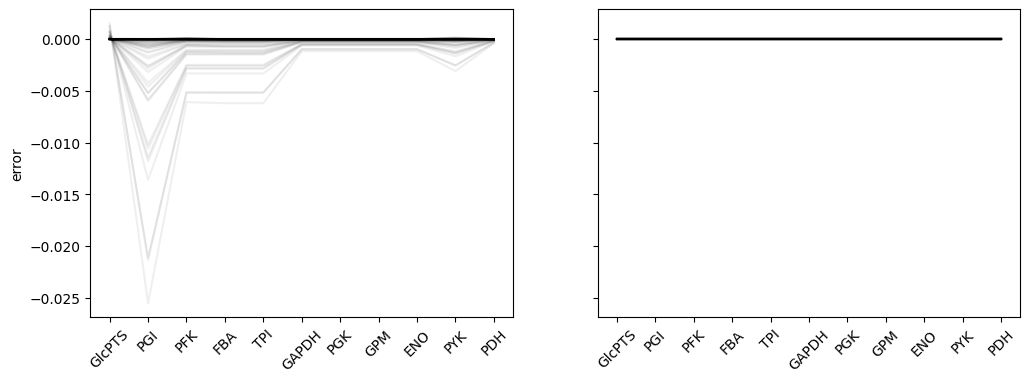

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey='all')
for result in results_a:
    ax[0].plot(np.log(result[active] / optimal_array[active]), color='#00000010')
for result in results_b:
    ax[1].plot(np.log(result[active] / optimal_array[active]), color='#00000010')

ax[0].set_ylabel('error')
ax[0].set_xticks(range(len(active_labels)), active_labels, rotation=45)
ax[1].set_xticks(range(len(active_labels)), active_labels, rotation=45)
plt.show()

And waaay more consistent

In [20]:
rms_error_a = [np.sqrt(np.mean(np.square(result - optimal_array))) for result in results_a]
print(f'minimize() rms error vs optimal: {np.mean(rms_error_a):.2e}')
rms_error_b = [np.sqrt(np.mean(np.square(result - optimal_array))) for result in results_b]
print(f'least_squares() rms error vs optimal: {np.mean(rms_error_b):.2e}')

minimize() rms error vs optimal: 2.85e-05
least_squares() rms error vs optimal: 3.03e-15


### One more time, with previous sparsity objective but using least_squares

In [21]:
objectives = {
    'steady-state': LegacyObjective(fba_gd.SteadyStateObjective(network, intermediates, weight=1e4)),
    'irreversibility': LegacyObjective(fba_gd.IrreversibilityObjective(network, weight=1e4)),
    'drivers': LegacyObjective(
        fba_gd.ProductionObjective(network, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0., KB('Glc.D.ext'): -0.03})),
    # 'non-futility': fba_gd.VelocityObjective(network, {KB('fbp'): 0., KB('pps'): 0.}),
    'sparsity': LegacyObjective(fba_gd.VelocityObjective(network, {rxn: 0.0 for rxn in network.reactions}, weight=1e-4), aggfun=l_pt5)
}

def residual(v, *params):
    dmdt = network.s_matrix @ v
    return jnp.concatenate([objective.residual(v, dmdt, p) * np.sqrt(objective.weight)
                            for objective, p in zip(objectives.values(), params)])

_loss_jit = jax.jit(residual)
_loss_jac = jax.jit(jax.jacfwd(residual))

params = tuple(objective.params() for objective in objectives.values())

In [22]:
%%time
results_c = [scipy.optimize.least_squares(fun=_loss_jit, args=params, x0=trial, jac=_loss_jac).x for trial in v0]

CPU times: user 519 ms, sys: 3.9 ms, total: 523 ms
Wall time: 520 ms


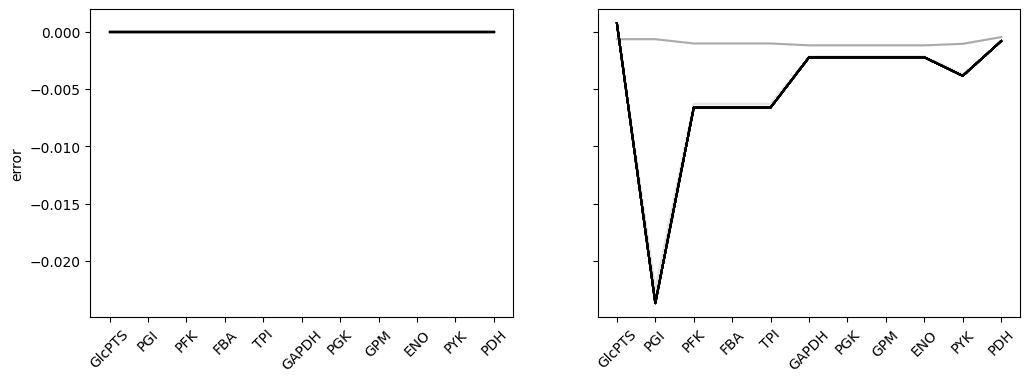

least_squares() with sparsity objective, rms error vs optimal: 3.42e-04


In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey='all')
for result in results_b:
    ax[0].plot(np.log(result[active] / optimal_array[active]), color='#00000010')
for result in results_c:
    ax[1].plot(np.log(result[active] / optimal_array[active]), color='#00000010')

ax[0].set_ylabel('error')
ax[0].set_xticks(range(len(active_labels)), active_labels, rotation=45)
ax[1].set_xticks(range(len(active_labels)), active_labels, rotation=45)
plt.show()

rms_error_c = [np.sqrt(np.mean(np.square(result - optimal_array))) for result in results_c]
print(f'least_squares() with sparsity objective, rms error vs optimal: {np.mean(rms_error_c):.2e}')

Unexpected: not just worse, but consistently incorrect, or at least not the intended optimal solution.

In [24]:
soln = scipy.optimize.least_squares(fun=_loss_jit, args=params, x0=v0[0], jac=_loss_jac, verbose=2)
dmdt = network.s_matrix @ soln.x
print(f"Fit: {sum(float(objectives[name].loss(soln.x, dmdt, None)) for name in ['steady-state', 'irreversibility'])}")
print(soln.x[active] / optimal_array[active])

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.1692e+05                                    8.93e+04    
       1              2         2.4312e+00      3.17e+05       4.82e+00       2.20e+02    
       2              3         1.1688e-06      2.43e+00       7.77e-02       7.32e-06    
       3              4         1.1688e-06      1.33e-14       4.11e-09       7.32e-06    
       4              5         1.1662e-06      2.65e-09       1.63e-03       9.69e-14    
`gtol` termination condition is satisfied.
Function evaluations 5, initial cost 3.1692e+05, final cost 1.1662e-06, first-order optimality 9.69e-14.
Fit: 7.634715111588004e-13
[1.0007293  0.97661217 0.99339939 0.99339949 0.99339954 0.99775893
 0.99775897 0.99775902 0.99775907 0.99614976 0.99916981]


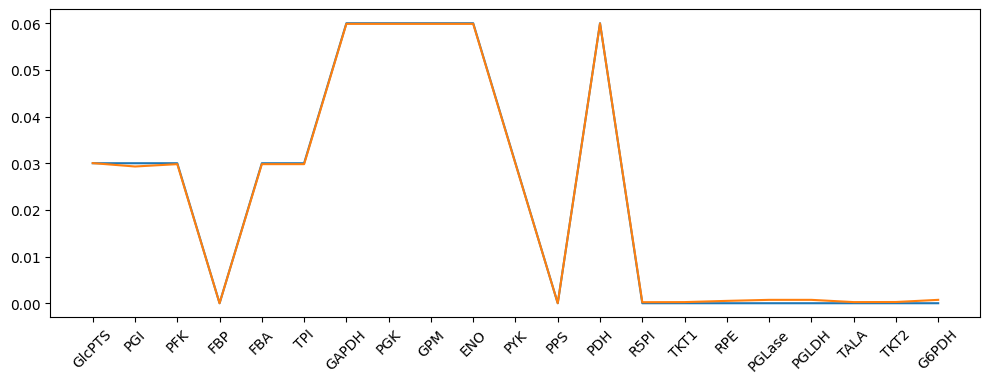

In [25]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.abs(optimal_array), label='expected')
ax.plot(np.abs(soln.x), label='found')
ax.set_xticks(range(network.shape[1]), network.reactions.labels(), rotation=45)
plt.show()


**Narrative**: 
- We disincentivize _all_ non-zero flux, with an L2 loss funciton.
- The system can reduce flux through PGI by bypassing via PPP.
- The beneift of reducing (squared) PGI flux compensates for the penalty of increased Glc consumption and/or reduced acCoA production.
- This is an uninteded artifact of the method we use to minimize futile cycles. An alternative approach is better.

### Build an objective explicitly to minimize flux in a futile cycle
- Added benefit: optimality drives the residual to zero instead of minimizing a positive number

In [26]:
class ExclusionObjective(fba_gd.Objective):
    """Incentivizes mutually exclusive fluxes within a set of reactions."""

    def __init__(self, network, reactions, weight=1.0):
        super().__init__(weight=weight)
        self.network = network
        self.indices = np.array([network.reactions.index_of(rxn) for rxn in reactions], dtype=np.int32)

    def residual(self, velocities, dmdt, params=None):
        return jnp.prod(velocities[self.indices], keepdims=True)


In [27]:
objectives = {
    'steady-state': LegacyObjective(fba_gd.SteadyStateObjective(network, intermediates, weight=1e4)),
    'irreversibility': LegacyObjective(fba_gd.IrreversibilityObjective(network, weight=1e4)),
    'drivers': LegacyObjective(
        fba_gd.ProductionObjective(network, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0., KB('Glc.D.ext'): -0.03})),
    'non-futility-fbp': LegacyObjective(ExclusionObjective(network, [KB('fbp'), KB('pfk')])),
    'non-futility-pps': LegacyObjective(ExclusionObjective(network, [KB('pps'), KB('pyk')])),
}

def residual(v, *params):
    dmdt = network.s_matrix @ v
    return jnp.concatenate([objective.residual(v, dmdt, p) * np.sqrt(objective.weight)
                            for objective, p in zip(objectives.values(), params)])

_loss_jit = jax.jit(residual)
_loss_jac = jax.jit(jax.jacfwd(residual))

params = tuple(objective.params() for objective in objectives.values())

In [28]:
%%time
results_d = [scipy.optimize.least_squares(fun=_loss_jit, args=params, x0=trial, jac=_loss_jac).x for trial in v0]

CPU times: user 598 ms, sys: 3.98 ms, total: 602 ms
Wall time: 599 ms


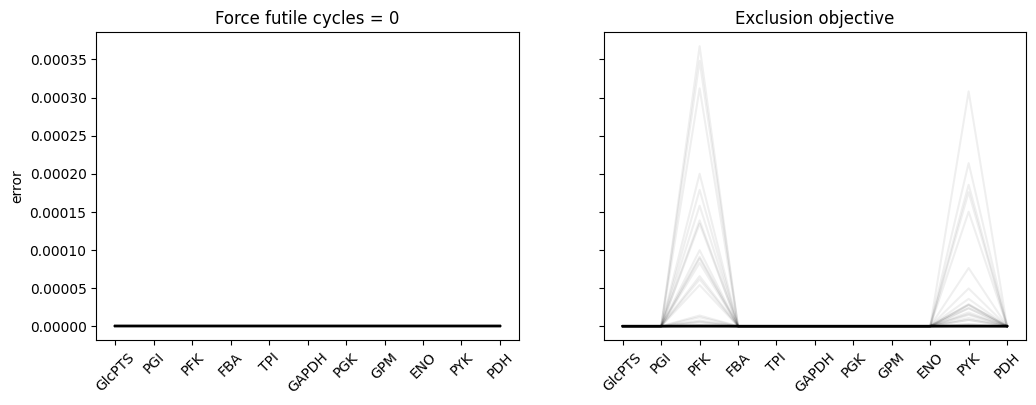

least_squares() with exclusion objective, rms error vs optimal: 3.56e-07


In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey='all')
ax[0].set_title("Force futile cycles = 0")
for result in results_b:
    ax[0].plot(np.log(result[active] / optimal_array[active]), color='#00000010')
ax[1].set_title("Exclusion objective")
for result in results_d:
    ax[1].plot(np.log(result[active] / optimal_array[active]), color='#00000010')

ax[0].set_ylabel('error')
ax[0].set_xticks(range(len(active_labels)), active_labels, rotation=45)
ax[1].set_xticks(range(len(active_labels)), active_labels, rotation=45)
plt.show()

rms_error_d = [np.sqrt(np.mean(np.square(result - optimal_array))) for result in results_d]
print(f'least_squares() with exclusion objective, rms error vs optimal: {np.mean(rms_error_d):.2e}')

- Better than sparsity, not as good as a pure zero velocity objective. 
- It does at least specifically target futile cycles.

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.1692e+05                                    8.93e+04    
       1              2         1.2237e-03      3.17e+05       4.85e+00       5.33e-02    
       2              3         3.2244e-05      1.19e-03       1.43e-01       8.50e-04    
       3              4         1.9069e-06      3.03e-05       6.25e-02       1.20e-04    
       4              5         9.5826e-08      1.81e-06       2.96e-02       1.78e-05    
       5              6         2.6130e-09      9.32e-08       1.20e-02       2.33e-06    
       6              7         9.6566e-12      2.60e-09       2.96e-03       1.32e-07    
       7              8         2.2151e-16      9.66e-12       2.05e-04       6.31e-10    
`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 3.1692e+05, final cost 2.2151e-16, first-order optimality 6.31e-10.
Fit: 4.815845522295488e-31
[ 3.46

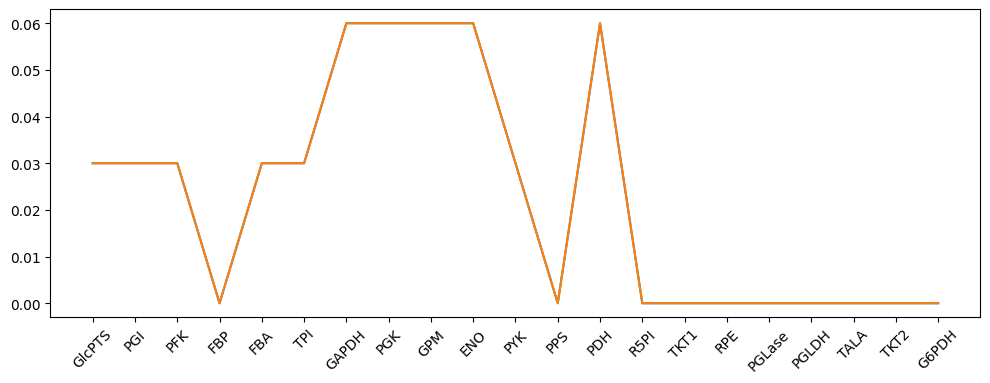

In [30]:
soln = scipy.optimize.least_squares(fun=_loss_jit, args=params, x0=v0[0], jac=_loss_jac, verbose=2)
dmdt = network.s_matrix @ soln.x
print(f"Fit: {sum(float(objectives[name].loss(soln.x, dmdt, None)) for name in ['steady-state', 'irreversibility'])}")
print(soln.x - optimal_array)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.abs(optimal_array), label='expected')
ax.plot(np.abs(soln.x), label='found')
ax.set_xticks(range(network.shape[1]), network.reactions.labels(), rotation=45)
plt.show()


**Conclusion**
- The graph two cells above highlights the difference between the exclusion objective and blocking FBP and PPS directly. But that difference is actually quite small, < ~0.03%
- The exclusion objective is flexible with respect to overall direction, where blocking specific fluxes would need to know which direction is expected.
- The tradeoff could be well worth it.